In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Environment Setup

### Check Version

#### Python Version

In [2]:
# Check Python Version
!python --version

Python 3.10.11


#### Ubuntu Version

In [3]:
# Check Ubuntu Version
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.5 LTS
Release:	20.04
Codename:	focal


#### Check CUDA Version

In [4]:
# Check CUDA/cuDNN Version
!nvcc -V && which nvcc

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
/usr/local/cuda/bin/nvcc


#### Check GPU Version

In [5]:
# Check GPU
!nvidia-smi

Sun Apr 30 03:49:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
This set up script:

1. Checks to make sure that the GPU is RAPIDS compatible
1. Installs the **current stable version** of RAPIDSAI's core libraries using pip, which are:
  1. cuDF
  1. cuML
  1. cuGraph
  1. xgboost

**This will complete in about 3-4 minutes**

Please use the [RAPIDS Conda Colab Template notebook](https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9) if you need to install any of RAPIDS Extended libraries, such as:
- cuSpatial
- cuSignal
- cuxFilter
- cuCIM

OR
- nightly versions of any library 

In [6]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 28, in <module>
    if ('K80' not in gpu_name):
TypeError: a bytes-like object is required, not 'str'


In [7]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVC, SVC
import random
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [9]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/IEEE-CIS/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1BUDjtdkbYP6ayadYsrcyHHHfPTJigLdc/IEEE-CIS


In [10]:
# load provided datasets
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

# combine datasets as needed
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

del train_transaction, train_identity

In [11]:
# The dataset are sparse, only consider the features with less than 30% missing data
valid_cols = pd.DataFrame(train.isnull().sum()/len(train)*100 < 30)
valid_cols = valid_cols[valid_cols[0] == True]
train = train[list(valid_cols.index)]

In [12]:
# Seperate categorical variables
train = train.astype({'ProductCD': 'category',
                   'card1': 'category','card2': 'category','card3': 'category','card4': 'category','card5': 'category','card6': 'category',
                   'addr1': 'category','addr2': 'category',
                   'P_emaildomain': 'category',
                   'M6': 'category'})

In [13]:
# Fill missing values in numerical columns
num_cols = train.select_dtypes(include=np.number).columns.tolist()
for column in num_cols:
    train[column].fillna(train[column].median(), inplace=True)

In [14]:
# seperate X and Y
train_X = train.drop(columns=['isFraud'])
train_Y = train['isFraud']

del train
X_dev, X_test, y_dev, y_test = train_test_split(train_X, train_Y, test_size=0.2, stratify=train_Y, random_state=42)
del train_X, train_Y

In [15]:
# drop high correlated (>0.9) features
corr_matrix = X_dev.corr().abs()

# create a mask for highly correlated features
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.9)]
X_dev = X_dev.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

<ipython-input-15-f57138035e0b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_dev.corr().abs()


In [16]:
# Encoding and StandardScaler
num_cols = X_dev.select_dtypes(include=np.number).columns.drop(['TransactionID']).tolist()
te_cols = ['TransactionID','card1', 'card2', 'addr1', 'card5', 'card3', 'addr2', 'P_emaildomain']
cat_cols = X_dev.select_dtypes(exclude=np.number).columns.drop(['card1', 'card2', 'addr1', 'card5', 'card3', 'addr2', 'P_emaildomain']).tolist()
ohe_features = cat_cols
num_features = num_cols
te_features = te_cols

preprocess = make_column_transformer((StandardScaler(), num_features), (OneHotEncoder(handle_unknown='ignore'), ohe_features), (ce.TargetEncoder(return_df=True), te_features))
preprocess.fit(X_dev, y_dev)
X_dev = preprocess.transform(X_dev)
X_test = preprocess.transform(X_test)

In [17]:
# SMOTE
smote = SMOTE(random_state=42)
X_dev, y_dev = smote.fit_resample(X_dev, y_dev)

In [18]:
X_dev.shape

(911804, 125)

In [19]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import optuna
from cuml.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import gc

gc.collect()
# Objective function for Random Forest Classifier
def rf_objective(trial):
    
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    max_features = trial.suggest_float("max_features", 0, 1)
    max_leaves = trial.suggest_int("max_leaves", 15, 127)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    
    hist_gb = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_leaves=max_leaves, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(hist_gb, X_dev, y_dev, cv=cv, scoring='roc_auc', n_jobs=1)
    gc.collect()

    return np.mean(auc_scores)


# Hist Gradient Boosting Classifier Hyperparameter Tuning
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=10)  # Increase the number of trials to 10


best_rf_params = rf_study.best_params

[I 2023-04-30 04:00:13,030] A new study created in memory with name: no-name-a86bab5f-1fc4-4505-b6c9-e27fa82ccbf7
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the e

In [29]:
rf_clf = RandomForestClassifier(**best_rf_params, random_state=42)
rf_clf.fit(X_dev, y_dev)

# Predict on the test set
rf_pred = rf_clf.predict(X_test)

# Calculate evaluation metrics

rf_precision = precision_score(y_test, rf_pred)

rf_recall = recall_score(y_test, rf_pred)

rf_avg_precision = average_precision_score(y_test, rf_pred)

# Print evaluation metrics
print("rf Classifier:")
print(f"AUC: {rf_auc:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"Average Precision-Recall: {rf_avg_precision:.4f}")


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


rf Classifier:
AUC: 0.7636
Precision: 0.3245
Recall: 0.5703
Average Precision-Recall: 0.2001


In [30]:
print("Best Hyperparameters: ", rf_study.best_params)

Best Hyperparameters:  {'n_estimators': 231, 'max_features': 0.5864271442625765, 'max_leaves': 85, 'max_depth': 10, 'min_samples_leaf': 14}


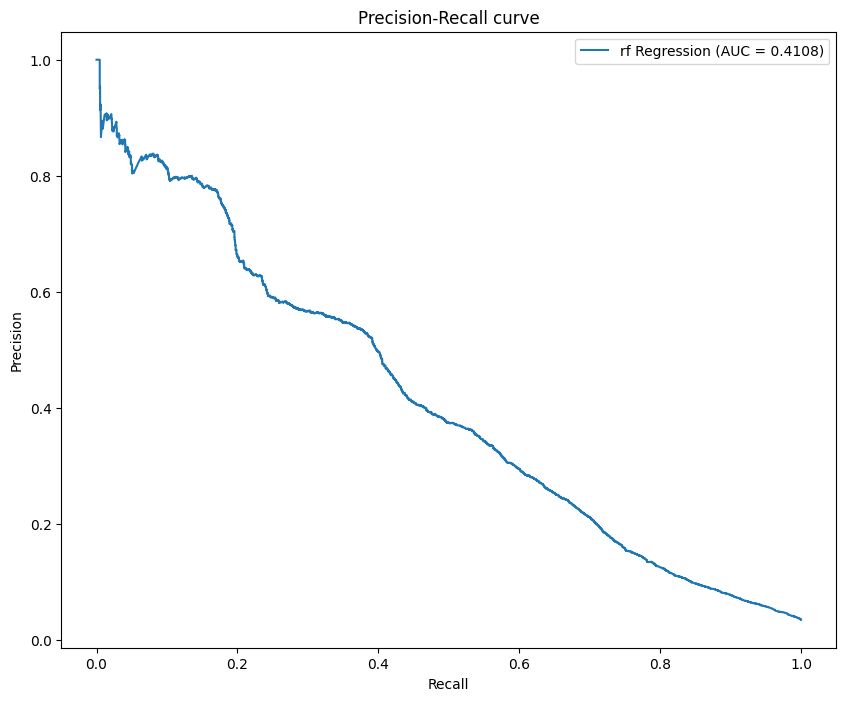

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Compute Precision-Recall curve
rf_prob = rf_clf.predict_proba(X_test)[:, 1]

rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_prob)

# Compute the AUC of the Precision-Recall curve
rf_pr_auc = auc(rf_recall, rf_precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(rf_recall, rf_precision, label=f'rf Regression (AUC = {rf_pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()

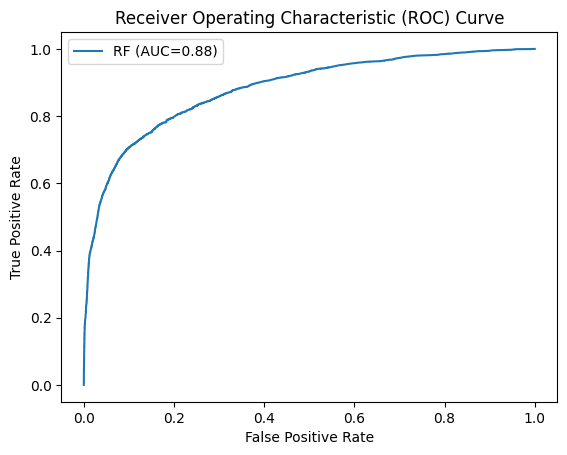

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf, pos_label=1)
auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={auc_rf:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.32      0.57      0.41      4133

    accuracy                           0.94    118108
   macro avg       0.65      0.76      0.69    118108
weighted avg       0.96      0.94      0.95    118108



In [34]:
import numpy as np

np.save('fpr_rf.npy', fpr_rf)
np.save('tpr_rf.npy', tpr_rf)